Estimating the size of the TESS/whatever dataset

In [23]:
# All guesses.
years = 8
sample_interval_min = 5
pixels_per_sample = 10 * 10
bytes_per_pixel = 4
stars = 2000

# Estimating the size.
minutes = years * 365 * 24 * 60
samples_per_star = minutes / sample_interval_min
total_size = samples_per_star * pixels_per_sample * bytes_per_pixel * stars

print(f'{total_size:,} bytes')

672,768,000,000.0 bytes


In [24]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [25]:
DATA = Path.cwd().parent / "data" / "CONFIRMED"

In [26]:
K2_3 = DATA / "K2-3.csv"

In [27]:
df = pd.read_csv(K2_3)

In [28]:
df.head()

,time,flux,flux_err
0,1977.242017,0.965237,0.000045
1,1977.262449,1.025735,0.000046
2,1977.282882,1.025550,0.000046
3,1977.303314,1.025327,0.000046
4,1977.323746,0.999550,0.000045


In [29]:
df.shape

(3738, 3)

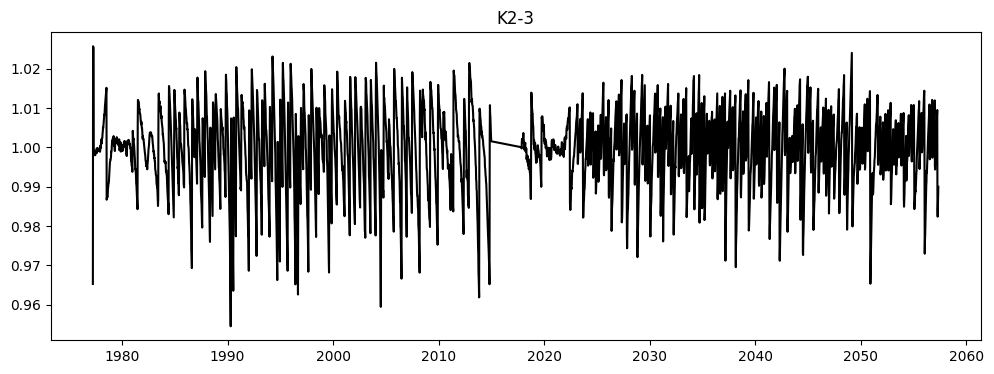

In [30]:
plt.figure(figsize=(12, 4))
plt.title("K2-3")
plt.plot(df["time"], df["flux"], "k-")
plt.show()

# Copying some code from astropy to learn

## Estimating periods

In [31]:
t = df["time"]
y = df["flux"]
dy = df["flux_err"]

In [32]:
real_period = 50
real_phase = 5
real_duration = 0.1 * real_period
real_diff = 0.05

threshold = np.cos(np.pi * real_duration / real_period)

t = np.linspace(0, 400, 4000)
y = (np.cos(2.0 * np.pi \
        * (t - real_phase - real_duration / 2.0) / real_period) > threshold) \
    .astype(float)
y = 1.0 - real_diff * y
dy = 0.01 * np.ones(t.shape)

In [33]:
df_fake_py = pd.DataFrame({"time": t, "flux": y, "flux_err": dy})

In [34]:
df_fake_py.to_csv("fake_py.csv", index=False)

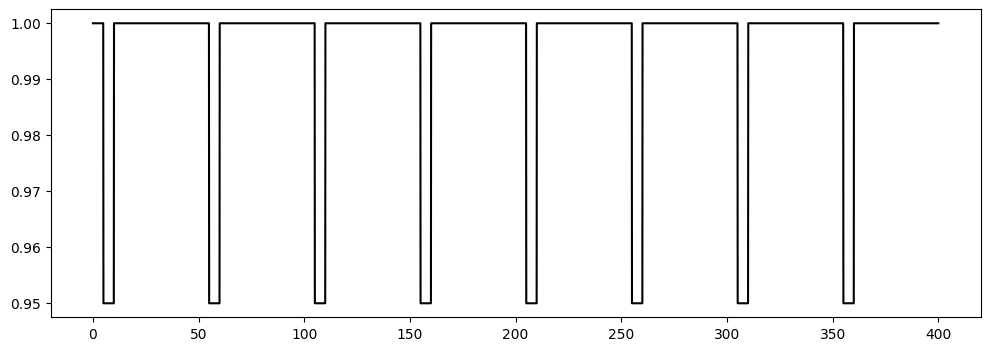

In [35]:
plt.figure(figsize=(12, 4))
plt.plot(t, y, "k-")
plt.show()

In [36]:
from utils import auto_max_min_period, autoperiod, autophase

minimum_period, maximum_period, total_duration = auto_max_min_period(t)
periods = autoperiod(minimum_period, maximum_period, total_duration)

print(minimum_period, maximum_period, total_duration, len(periods))

0.20005001250308396 200.0 400.0 1998


In [37]:
import sys

from tqdm import tqdm

In [38]:
def spec_generator(t):
    periods = autoperiod(*auto_max_min_period(t))
    step = np.ptp(t) / len(t)
    # step *= step
    print(f"Step: {step}")
    for p in tqdm(periods):
        durations = np.arange(0.01 * p, 0.05 * p, step)
        for d in durations:
            phase = autophase(period=p, duration=d)
            for phi in phase:
                yield p, d, phi

def spec_gen_gambiarra():
    for p in tqdm(np.linspace(45, 55, 101)):
        for d in np.linspace(1, 11, 11):
            for phi in np.arange(0, p, 0.5):
                with open("spec_py.csv", "a") as f:
                    f.write(f"{p},{d},{phi}\n")
                yield p, d, phi


def compute_trel(t):
    trel = t - np.min(t)
    return trel


def normalize(y):
    y -= np.mean(y)
    y /= (np.std(y) + sys.float_info.epsilon)
    return y


def compute_weights(dy):
    w = 1.0 / dy**2
    assert np.fabs(np.sum(w)) > sys.float_info.epsilon
    w = w / np.sum(w)
    return w


In [39]:
from numba import cuda, jit, njit


@njit(parallel=True)
def model(trel, y, w, period, duration, phase):
    is_transit = \
        (np.fmod(trel, period) >= phase) & \
        (np.fmod(trel, period) <= phase + duration)
    r = np.sum(w * is_transit)
    s = np.sum(w * y * is_transit)
    wx = np.sum(w * y * y)
    d_value = wx - (s**2) / (r * (1 - r) + np.finfo(np.float64).eps)
    return d_value


def new_bls(t, y, dy, spec_generator):
    trel = compute_trel(t)
    y = normalize(y)
    w = compute_weights(dy)

    best_d_value = np.inf
    best_period = None
    best_duration = None
    best_phase = None

    for period, duration, phase in spec_generator:
        d_value = model(trel, y, w, period, duration, phase)

        if d_value < best_d_value:
            best_d_value = d_value
            best_period = period
            best_duration = duration
            best_phase = phase

    return best_period, best_duration, best_phase, best_d_value

In [40]:
import torch


@torch.no_grad()
def model_torch(trel, y, w, period, duration, phase):
    is_transit = \
        (torch.remainder(trel, period) >= phase) & \
        (torch.remainder(trel, period) <= phase + duration)
    r = torch.sum(w * is_transit, axis=1)
    s = torch.sum(w * y * is_transit, axis=1)
    wx = torch.sum(w * y * y, axis=1)
    d_value = wx - (s**2) / (r * (1 - r) + torch.finfo(torch.float64).eps)
    return d_value


@torch.no_grad()
def new_bls_torch(t, y, dy, spec_generator):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    trel = torch.tensor(compute_trel(t), device=device).reshape(1, -1)
    y = torch.tensor(normalize(y), device=device).reshape(1, -1)
    w = torch.tensor(compute_weights(dy), device=device).reshape(1, -1)

    best_d_value = np.inf
    best_period = None
    best_duration = None
    best_phase = None

    batch_size = 512

    periods = []
    durations = []
    phases = []

    for k, (period, duration, phase) in enumerate(spec_generator):
        periods.append(period)
        durations.append(duration)
        phases.append(phase)

        if (k + 1) % batch_size == 0:
            periods = torch.tensor(periods, device=device).reshape(-1, 1)
            durations = torch.tensor(durations, device=device).reshape(-1, 1)
            phases = torch.tensor(phases, device=device).reshape(-1, 1)

            d_value = model_torch(trel, y, w, periods, durations, phases)

            d_value, d_value_index = torch.min(d_value, dim=0)

            if d_value < best_d_value:
                best_d_value = d_value.item()
                best_period = periods[d_value_index].item()
                best_duration = durations[d_value_index].item()
                best_phase = phases[d_value_index].item()

            periods = []
            durations = []
            phases = []

    return best_period, best_duration, best_phase, best_d_value

In [41]:
spec_gen = spec_generator(t)
# spec_gen = spec_gen_gambiarra()
best_period, best_duration, best_phase, best_d_value = \
    new_bls_torch(t, y, dy, spec_gen)

Step: 0.1


100%|██████████| 1998/1998 [00:00<00:00, 50688.45it/s]


In [42]:
best_period, best_duration, best_phase, best_d_value

(159.99999999323336, 4.399999999932336, 145.45454545063077, 0.9600090888434161)

In [43]:
# spec_gen = spec_generator(t)
spec_gen = spec_gen_gambiarra()
best_period, best_duration, best_phase, best_d_value = \
    new_bls(t, y, dy, spec_gen)

100%|██████████| 101/101 [00:25<00:00,  3.95it/s]


In [44]:
best_period, best_duration, best_phase, best_d_value

(np.float64(50.0), np.float64(5.0), np.float64(5.0), 3.6637359812630166e-15)